In [1]:
import os, sys
from pprint import pprint

sys.path.append('../')
import modules

sys.path.append('../reframe')
import reframe_imb

In [2]:
# NB: this is based on paths looking like:
# ../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out 
# ../perflogs/alaska/compute-roce/gnu-openmpi/IMB_PingPong/IMB_PingPong.log

In [3]:
# find and load output files:
run_outputs = modules.utils.find_run_outputs('../output', 'IMB')

# load results using the same function that we use for reframe performance tests:
results = []
for path in run_outputs:
    result = reframe_imb.read_imb_out(path)
    results.append(result)

# Group results by *testname*
test_results = modules.utils.group_by(results, lambda x: x['meta']['testname'])

print('loaded %s output files from %i tests' % (len(results), len(test_results)))
for test, cases in test_results.items():
    print(test, ':')
    for c in cases:
        print('  ', c['meta']['path'])
#         print('    ',c['meta']['environ'])
#         print('    ',c['meta']['partition'])

loaded 11 output files from 3 tests
IMB_Biband :
   ../output/alaska/roce-openmpi3-openib/imb/IMB_Biband/rfm_IMB_Biband_job.out
   ../output/alaska/roce-openmpi4-ucx/imb/IMB_Biband/rfm_IMB_Biband_job.out
   ../output/alaska/ib-openmpi4-ucx/imb/IMB_Biband/rfm_IMB_Biband_job.out
IMB_PingPong :
   ../output/alaska/roce-openmpi3-openib/imb/IMB_PingPong/rfm_IMB_PingPong_job.out
   ../output/alaska/roce-openmpi4-ucx/imb/IMB_PingPong/rfm_IMB_PingPong_job.out
   ../output/alaska/ib-openmpi3-openib/imb/IMB_PingPong/rfm_IMB_PingPong_job.out
   ../output/alaska/ib-openmpi4-ucx/imb/IMB_PingPong/rfm_IMB_PingPong_job.out
IMB_Uniband :
   ../output/alaska/roce-openmpi3-openib/imb/IMB_Uniband/rfm_IMB_Uniband_job.out
   ../output/alaska/roce-openmpi4-ucx/imb/IMB_Uniband/rfm_IMB_Uniband_job.out
   ../output/alaska/ib-openmpi3-openib/imb/IMB_Uniband/rfm_IMB_Uniband_job.out
   ../output/alaska/ib-openmpi4-ucx/imb/IMB_Uniband/rfm_IMB_Uniband_job.out


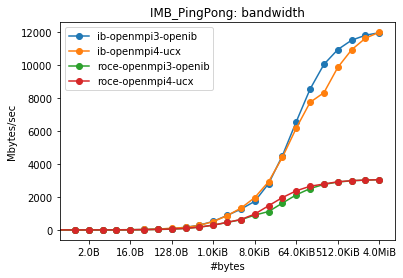

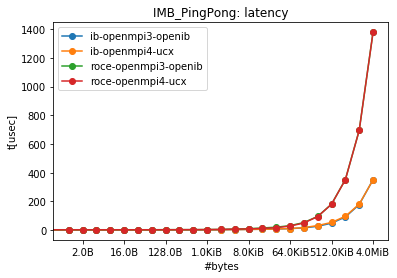

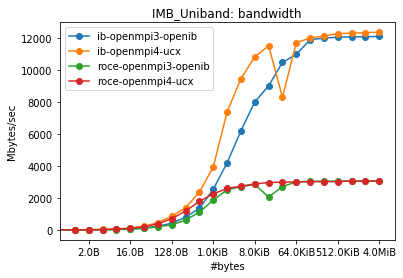

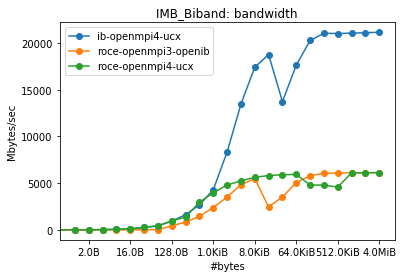

In [4]:
# Plotting:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker

PLOTS = [
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'t[usec]',
        'metric':'latency',
    },
    {
        'test':'IMB_Uniband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_Biband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },   
]

for plot in PLOTS:
    
    cases = test_results[plot['test']]
    
    # add a label to each case based on unique metadata:
    common, differences = modules.utils.diff_meta(cases)
    for ix, unique_meta in enumerate(differences):
        cases[ix]['label'] = '-'.join(list(unique_meta.values()))
    
    # sort cases by label:
    cases = sorted(cases, key=lambda c: c['label'])
    
    plt.figure()
    for ix, case in enumerate(cases):
        
        data = case['data'] # TODO: change this cope with benchmark name in output instead of fixed "data" key
        
        #plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=case['label'])
        plt.grid()
        plt.title('%s: %s' % (plot['test'], plot['metric']))
        plt.legend()
        plt.grid()
        ax = plt.gca()
        ax.set_xscale('log', basex=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
        plt.xlabel(plot['xaxis'])
        plt.ylabel(plot['yaxis'])
    

In [5]:
# example of loading test objects - don't actually need this yet

# def get_tests(module):
#     tests = []
#     for name in dir(module):
#         obj = getattr(module, name)
#         if isinstance(obj, reframe.core.meta.RegressionTestMeta):
#             tests.append(obj)
#     return tests
# testobjs = get_tests(reframe_imb)
# print(testobjs)

In [6]:
# Load performance records

# find relevant perf logs:
perf_outputs = modules.utils.find_run_outputs('../perflogs', 'IMB', '.log')

# load them:
perf_records = []
for path in perf_outputs:
    records = modules.utils.read_perflog(path)
    perf_records.append(records)

# group performance data by testname:
test_perf = modules.utils.group_by(perf_records, lambda x: x['meta']['testname'])

print('loaded %s performance logs from %i tests' % (len(perf_outputs), len(test_perf)))

loaded 11 performance logs from 3 tests


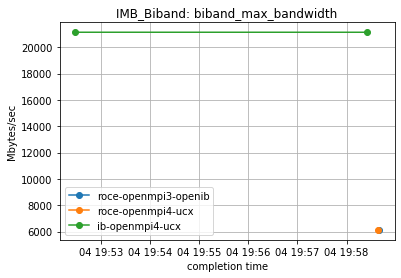

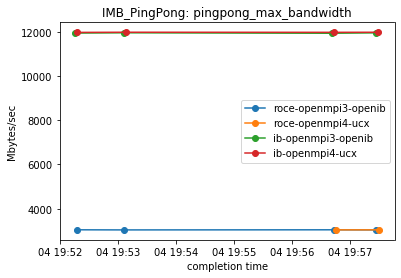

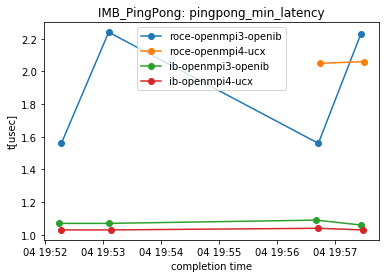

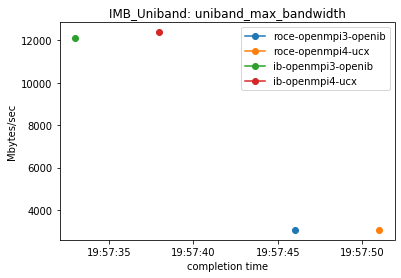

In [7]:
# Plot: NB for perf logs we don't need to define the plots because they can automatically be derived

import datetime

from matplotlib.dates import date2num

# plotting:
for test in test_perf:
    axes = {}
    cases = test_perf[test]
    common, differences = modules.utils.diff_meta(cases)
    for ix, case in enumerate(cases):
        
        unique_meta = differences[ix]
        for perf_var in case:
            if perf_var == 'meta': # not a real performance var
                continue
            
            # annoyingly can't use setdefault as this always evalutes `default`, so:
            if perf_var not in axes:
                axes[perf_var] = plt.subplots(nrows=1, ncols=1)
            fig, ax = axes[perf_var]            
            dates = case[perf_var]['completion_time']
            values = case[perf_var]['perf_value']
            label = '-'.join(list(unique_meta.values()))
            ax.plot_date(dates, values, 'o-', label=label)
            ax.set_title('%s: %s' % (test, perf_var))
            ax.legend()
            ax.grid()
            ax.set_xlabel('completion time')
            ax.set_ylabel(case[perf_var]['perf_unit'][0]) # shouldn't matter which unit is used
        